# Sheet5 Leonhard Moske


In [1]:
import numpy as np
import itertools as it
import sympy

def genBasis(L, s): #L number of spins, s total spin
    posSpins = np.linspace(-s, s, int((2*s+1)), dtype = float)#generate List of all possible z projections
    #print("possible Spins ", posSpins)
    tmp = it.product(posSpins, repeat = L) # generate object that itterates over all combinations
    return np.asarray([i for i in tmp]) # assemble the list

def Splus(oldcoef, state, site): # site counted from 0 , passed with copy
                        # return new coefficient and new state 
    if (state[site] == 0.5): #s): # if state is s the operator will return 0
        return 0, np.zeros(L)
    # coef = 1  #s = 1/2 #coef = np.sqrt(s*(s+1) - state[site] * (state[site] + 1)) #calculate new coef
    state[site] = 0.5 #state[site] + 1 # update spin state
    return oldcoef, state 

def Sminus(oldcoef, state, site): # analog to Splus
    if (state[site] == -0.5): # -s ):
        return 0, np.zeros(L)
    # coef = 1 #coef = np.sqrt(s*(s+1) - state[site] * (state[site] - 1))
    state[site] = -0.5 # state[site] - 1
    return oldcoef, state #coef*oldcoef 

def Sz(coef, state, site): 
    return state[site]*coef, state

def Hamiltonian(J, statei, L, statej, s):
    H = 0
    # if (np.array_equal(statei, statej)): # is in HamiltonianDiag
    #     for i in range(L):
    #         H += statei[i]*statei[(i+1)%L] * J
            #H += Sz(*Sz(1, np.copy(statei), (i+1)%L), i)[0] * J
    for i in range(L): #apply the operators to every site until L-1
        coef1, state1 = Splus(*Sminus(1, np.copy(statei),(i+1)%L), i)
        coef2, state2 = Sminus(*Splus(1, np.copy(statei), (i+1)%L), i)
        #coef3, state3 = Sz(*Sz(1, np.copy(statei), i+1), i)
        if np.array_equal(state1, statej): #compare if (<i|H)|j> is 0 for every term
            H += coef1*J*0.5
        if np.array_equal(state2, statej):
            H += coef2*J*0.5
        #if np.array_equal(state3, statej):
        #    H += coef3 * J
    return H

def HamiltonianDiag(J, statei, L):
    H = 0
    for i in range(L):
        H += statei[i]*statei[(i+1)%L] * J
    return H


def calcMatrix(Basis, J, L, s):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.empty((len(Basis),len(Basis)))
    for i in range(len(Basis)):
        Matrix[i,i] = HamiltonianDiag(J, Basis[i], L)
    for i, j in it.permutations(range(len(Basis)), 2):
        Matrix[i,j] = Hamiltonian(J, Basis[i], L, Basis[j], s)
    return Matrix 


def totalZ(state, L):
    totalZ = 0
    for i in range(L):
        totalZ += Sz(1, state, i)[0]
    return totalZ

def splitBasisTotZ(Basis, L):
    splitBasis= []
    stot = []
    sortedBasis = sorted(Basis, key = lambda state : (totalZ(state, L)))
    tmpBasis = []
    oldz = totalZ(sortedBasis[0],L)
    for state in sortedBasis:
        z = totalZ(state, L)
        if z != oldz:
            splitBasis.append(tmpBasis)
            stot.append(totalZ(state, L))
            tmpBasis = [state]
            oldz = z
        else:
            tmpBasis.append(state)
            oldz = z
    splitBasis.append(tmpBasis)
    stot.append(totalZ(state, L))
    return splitBasis, stot

def totalZmatrix(Basis, L):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.zeros((len(Basis),len(Basis))) # since we know that the basisstates are eigenstates of totalZ we only have to compute the diagonal 
    for i in range(len(Basis)):
        Matrix[i,i] = totalZ(Basis[i], L)
    return Matrix

def transition(state): # numpy array
    newState = np.roll(state,1)
    return newState

def genFamily(state, operator, L): # generate the family of a state with an operator
    """generate the family of a state with an operator"""
    family = np.asarray([state])
    for r in range(1,L):
        family = np.append(family, [operator(family[-1])], axis=0)
    return family

def get_representativ(state, operator, L):
    family = genFamily(state, operator, L)
    tmp = np.copy(family)
    for i in range(len(family[0])): # over the length of the states
       family = family[family[:,i].argsort()]
    for i, s in enumerate(tmp):
        if np.all(s == family[0] ):
            return family[0] ,i
    return family[0] 

def get_norm(state, nk,operator, L ):
    k=2.*np.pi*nk/L
    fam = genFamily(state,operator,L)

    different_states = set()
    for s in fam:
        different_states.add(tuple(s))
    
    prefactors = {s:0.0 for s in different_states}
    
    for r, s, in enumerate(fam):
        prefactors[tuple(s)] += np.exp(1.j*k*r)
    
    norm = 0.0
    for s in prefactors:
        norm += np.abs( prefactors[s] )**2
        
    return np.sqrt(norm)

def calcHam(basis, L,operator):
    hamils = []
    reps={}

    # Create set of representative states, including family size
    for s in basis:
        rep,fam = get_representativ(s,operator,L)[0], genFamily(s,operator,L)[0]
        reps[tuple(rep)] = len(np.unique(fam, axis = 0))

    dim_sum=0

    for nk in range(L):
        nk = nk  # momentum sector
        k=2.*np.pi*nk/L
        sector_reps={}
        
        index = 0
        for rep in reps.keys():
            norm = get_norm(rep,nk, operator, L)
            if abs(norm)>1e-6:
                sector_reps[tuple(rep)] = (norm, index) # for each representative state, we need to get the norm of its corresponding momentum state, and its index in our basis order
                index+=1
        dim=len(list(sector_reps))
        dim_sum+=dim
        
        print("Got momentum sector nk={} of size {}".format(nk, dim))
        
        Hk = np.zeros( (dim,dim) , dtype=np.complex128 )
        for rep in sector_reps.keys():
            
            norm, index = sector_reps[rep]
            matel=0.0
            ## diagonal terms
            for site in range(L):
                matel+=rep[site]*rep[(site+1)%L]
            Hk[index,index]=matel
                    
            # offdiagonal matrix elements
            for site in range(L):
                if rep[site]!=rep[(site+1)%L]:
                    state2=list(rep)
                    state2[site], state2[(site+1)%L] =  state2[(site+1)%L], state2[site]
                    rep2, num_translations_to_get_rep = get_representativ(state2, operator, L)
                    #print(state2,rep2)
                    
                    if tuple(rep2) in sector_reps:
                        norm2, idx2 = sector_reps[tuple(rep2)]
                        matel = 0.5*norm2/norm*np.exp(-1.j*k*num_translations_to_get_rep)
                        Hk[index,idx2]+=matel
        hamils.append(Hk)
    return hamils
    

## Some sanity checks

In [2]:
testindex = 9

L = 7

a = genBasis(L,0.5)
print(Splus(1,np.copy(a[testindex]), 1))
print(a[testindex], len(a))

print(transition(a[testindex]))



(1, array([-0.5,  0.5, -0.5,  0.5, -0.5, -0.5,  0.5]))
[-0.5 -0.5 -0.5  0.5 -0.5 -0.5  0.5] 128
[ 0.5 -0.5 -0.5 -0.5  0.5 -0.5 -0.5]


In [3]:

print(genFamily(a[testindex],transition,L), "RESULT")
print(get_representativ(a[testindex],transition,L))
print(get_norm([0.5,-0.5,0.5,-0.5],2,transition,L))


[[-0.5 -0.5 -0.5  0.5 -0.5 -0.5  0.5]
 [ 0.5 -0.5 -0.5 -0.5  0.5 -0.5 -0.5]
 [-0.5  0.5 -0.5 -0.5 -0.5  0.5 -0.5]
 [-0.5 -0.5  0.5 -0.5 -0.5 -0.5  0.5]
 [ 0.5 -0.5 -0.5  0.5 -0.5 -0.5 -0.5]
 [-0.5  0.5 -0.5 -0.5  0.5 -0.5 -0.5]
 [-0.5 -0.5  0.5 -0.5 -0.5  0.5 -0.5]] RESULT
(array([ 0.5, -0.5, -0.5,  0.5, -0.5, -0.5, -0.5]), 4)
1.1341112221539742


In [4]:
import sympy
sympy.Matrix(calcHam(genBasis(L,0.5),L,transition)[1])

Got momentum sector nk=0 of size 20
Got momentum sector nk=1 of size 18
Got momentum sector nk=2 of size 18
Got momentum sector nk=3 of size 18
Got momentum sector nk=4 of size 18
Got momentum sector nk=5 of size 18
Got momentum sector nk=6 of size 18


Matrix([
[1.37348980185873 + 5.55111512312578e-17*I,                                       0,                                       0,                                       0,                                          0,                                        0,                                       0,                                       0,                                        0,                                        0,                                        0,                                        0,                                        0,                                       0,                                        0,                                       0,                                          0,                                         0],
[                                        0,                                    0.75, 0.811744900929367 - 0.390915741234015*I,                                       0,                                          0,                        

In [5]:
dimsum = 0
L = 5
for nk in range(L):
    sector_reps={}
    for s in genBasis(L,0.5):
        rep , xl = get_representativ(s,transition,L)
        #fam = genFamily(rep)
        norm=get_norm(rep,nk,transition,L)
        if norm>1e-6: 
            if tuple(rep) not in sector_reps:
                sector_reps[tuple(rep)]=norm
    secdim = len(sector_reps.keys())
    print(nk, secdim)
    dimsum+=secdim
print("total ", dimsum, " should be ", 2**L)

0 8
1 6
2 6
3 6
4 6
total  32  should be  32


In [6]:
splitBasis, sZtot = splitBasisTotZ(genBasis(L,0.5),L)
if L%2 == 0:
    ind = sZtot.index(0)
    testham = calcHam(splitBasis[ind],L,transition)[1]
else:
    ind = sZtot.index(0.5)
    testham = calcHam(splitBasis[ind],L,transition)[1]

Got momentum sector nk=0 of size 2
Got momentum sector nk=1 of size 2
Got momentum sector nk=2 of size 2
Got momentum sector nk=3 of size 2
Got momentum sector nk=4 of size 2


## Exercise 13

2
4
6
8


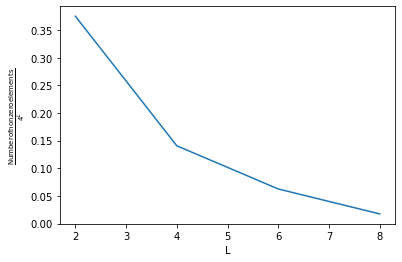

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def csr(matrix): #matrix has to be rows in first dimension
    elements , coloumns, pointer = [] , [], [0] # generate output arrays
    for row in matrix:
        elements = np.append(elements, row[np.nonzero(row)]) # append all nonzero elements
        coloumns = np.append(coloumns, np.nonzero(row)) # append the row indices with nonzero elements
        pointer = np.append(pointer,np.count_nonzero(row) + pointer[-1]) # append the number of all nonzero elements up until that row
    return elements, [int(c) for c in coloumns], pointer

def matrixVectorproduct(Matrix,vector): # simple matrix vector product with a csr matrix 
    e, c, p  = csr(Matrix)
    returnVec = []
    for i in range(len(vector)):
        returnVec.append(np.sum(np.multiply(np.take(vector,c[p[i]:p[i+1]]),e[p[i]:p[i+1]])))
    return returnVec

# testing
matrix = np.asanyarray([[0,0,1,0],[3,2,0,0],[0,0,4,0],[0,0,0,0]])
#print(csr(matrix))
vec = np.asarray([1,2,3,4])
#print(matrixVectorproduct(matrix,vec))



Ls = [2,4,6,8]#,10 ,12,14,16] #not realy feasable timewise with my hamiltonian implementation 
numberNonzeroNormalized = []
ham = 0

for L in Ls:
    print(L)
    ham = calcMatrix(genBasis(L,0.5),1,L,0.5)
    numberNonzeroNormalized.append(len(csr(ham)[0]) / (4**L))

plt.plot(Ls,numberNonzeroNormalized)
plt.xlabel("L")
plt.ylabel(r"$\frac{\mathrm{Number of nonzero elements}  }{4^L}$")
plt.show()



In [16]:
from scipy.sparse import csr_matrix 

L = Ls[-1]

v0 = np.random.rand(2**L)

v1 = matrixVectorproduct(ham, v0)
v2 = csr_matrix(ham).dot(v0)

print(np.any(np.abs(np.add(v1, -v2)) >= 0.1)) # test if the difference of the output vectors is greater than 0

False


## Exercise 14

In [27]:
# %%
from scipy.sparse import csr_matrix 

def lancoz(A, v_un, m): #A is scipy sparse matrix
    n = len(v_un)
    alpha = np.empty(m)
    beta = np.empty(m)
    v = np.empty((m+1,n))
    v0 = v_un / np.linalg.norm(v_un)
    v[0] = v0
    beta[0] = 0
    w = A.dot(v[0])
    alpha[0] = np.dot(w,v[0])
    w = np.add(w, -1*alpha[0]*v[0])
    beta[1] = np.linalg.norm(w)
    v[1] = w/beta[1]
    for j in range(1,m-1):
        # print(v)
        w = np.add(A.dot(v[j]), (-1)*beta[j]*v[j-1])
        alpha[j] =  np.dot(w,v[j])
        w = np.add(w, -1*alpha[j]*v[j]) 
        beta[j+1] = np.linalg.norm(w)
        v[j+1] = w/beta[j+1]
    return v, alpha, beta[1:]

Ls = [2,3,4,5,6,7,8]
for L in Ls:
    m = L # for these dimension the lancoz algorithm is not the bottleneck
    mat = csr_matrix(calcMatrix(genBasis(L,0.5),1,L,0.5))
    H = calcMatrix(genBasis(L,0.5),1,L,0.5)

    v0 = np.random.rand(2**L)
    v , alpha, beta = lancoz(mat,v0,m)

    T = np.zeros((m,m))

    for i in range(m):
        T[i,i] = alpha[i]
    for i in range(m-1):
        T[i,i+1] = beta[i]
        T[i+1,i] = beta[i]

    eigenT = np.linalg.eigvals(T)
    eigenH = np.linalg.eigvals(H)

    print(L )
    print(np.sort(np.unique(np.round(eigenH,decimals=3))))
    print(np.sort(np.round(eigenT,decimals=3)))

2
[-1.5  0.5]
[-0.613  0.552]
3
[-0.75  0.75]
[-0.75 -0.5   0.75]
4
[-2. -1.  0.  1.]
[-1.564 -0.564  0.187  1.004]
5
[-1.868+0.j -0.75 +0.j -0.559+0.j  0.368+0.j  0.559+0.j  1.25 +0.j]
[-1.868 -0.654 -0.429  0.489  1.25 ]
6
[-2.803 -2.118 -1.5   -1.281 -1.    -0.5   -0.     0.118  0.5    0.781
  0.803  1.     1.5  ]
[-2.772 -1.704 -0.954  0.102  0.902  1.5  ]
7
[-2.855+0.j -1.806+0.j -1.769+0.j -1.25 +0.j -1.112+0.j -0.822+0.j
 -0.75 +0.j -0.621+0.j -0.218+0.j -0.169+0.j -0.151+0.j  0.29 +0.j
  0.527+0.j  0.75 +0.j  0.799+0.j  1.115+0.j  1.168+0.j  1.373+0.j
  1.75 +0.j]
[-2.856 -1.808 -1.065 -0.48   0.557  1.213  1.75 ]
8
[-3.651+0.j -3.128+0.j -2.7  +0.j -2.459+0.j -2.145+0.j -1.855+0.j
 -1.802+0.j -1.707+0.j -1.618+0.j -1.267+0.j -1.202+0.j -1.144+0.j
 -1.   +0.j -0.859+0.j -0.761+0.j -0.726+0.j -0.628+0.j -0.597+0.j
 -0.513+0.j -0.445+0.j -0.437+0.j -0.293+0.j -0.259+0.j -0.   +0.j
  0.265+0.j  0.293+0.j  0.377+0.j  0.437+0.j  0.452+0.j  0.618+0.j
  0.893+0.j  1.   +0.j  1.144+0.j

## Exercise 15

In [10]:
def create_Hk_spinsec(L,nk,spinsec):
    splitBasis, sZtot = splitBasisTotZ(genBasis(L,0.5),L)
    ind = sZtot.index(spinsec)
    ham = calcHam(splitBasis[ind],L,transition)[nk]
    return csr_matrix(ham)

mat = csr_matrix(testham)
mat = mat.astype(np.float)
v0 = np.random.rand(len(testham[0]))
m = 7
v , alpha, beta = lancoz(mat,v0,m)


T = np.zeros((m,m))

for i in range(m):
    T[i,i] = alpha[i]
for i in range(m-1):
    T[i,i+1] = beta[i]
    T[i+1,i] = beta[i]

eigenT = np.linalg.eigvals(T)
print(eigenT)
print(v,alpha,beta)

[ 0.46196676 -1.77098375  0.46196676 -1.77098375  0.46196676 -1.77098375
  0.05629612]
[[ 0.70940915  0.7047969 ]
 [ 0.7047969  -0.70940915]
 [-1.          0.        ]
 [ 0.         -1.        ]
 [-1.          0.        ]
 [ 0.         -1.        ]
 [-1.          0.        ]
 [ 0.5         0.5       ]] [ 0.00588589 -1.31490288  0.25       -1.55901699  0.25       -1.55901699
  0.05629612] [9.00220111e-01 1.11022302e-16 6.54508497e-01 2.22044605e-16
 6.54508497e-01 3.33066907e-16]


/usr/lib/python3/dist-packages/scipy/sparse/data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),
